In [94]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from itertools import product
from tqdm import tqdm

import warnings

warnings.filterwarnings("ignore")

print("GPU available:", torch.cuda.is_available())

GPU available: True


## Transformer Model

In [ ]:
train_data = pd.read_csv("./wids/processed_train_data.csv")
test_data = pd.read_csv("./wids/processed_test_data.csv")

In [3]:
print("Train Data Shape:", train_data.shape)
print("Test Data Shape:", test_data.shape)
print("Train Data Columns:", train_data.columns)
print("Test Data Columns:", test_data.columns)

Train Data Shape: (1104, 19923)
Test Data Shape: (474, 19922)
Train Data Columns: Index(['age', 'bmi', 'p_factor_fs', 'internalizing_fs', 'externalizing_fs',
       'attention_fs', 'sex_Male', 'study_site_HBNsiteCUNY',
       'study_site_HBNsiteRU', 'study_site_HBNsiteSI',
       ...
       'feature_19890', 'feature_19891', 'feature_19892', 'feature_19893',
       'feature_19894', 'feature_19895', 'feature_19896', 'feature_19897',
       'feature_19898', 'feature_19899'],
      dtype='object', length=19923)
Test Data Columns: Index(['bmi', 'p_factor_fs', 'internalizing_fs', 'externalizing_fs',
       'attention_fs', 'sex_Male', 'study_site_HBNsiteCUNY',
       'study_site_HBNsiteRU', 'study_site_HBNsiteSI',
       'ethnicity_Not_Hispanic_or_Latino',
       ...
       'feature_19890', 'feature_19891', 'feature_19892', 'feature_19893',
       'feature_19894', 'feature_19895', 'feature_19896', 'feature_19897',
       'feature_19898', 'feature_19899'],
      dtype='object', length=19922)


Splitting data: 15% of validation and the rest for training

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    train_data.drop(columns=["age", "participant_id"]),  # Features
    train_data["age"],  # Target
    test_size=0.15,  # 15% for testing
    random_state=42314,  # For reproducibility
    stratify=train_data["sex_Male"]  # Stratify by sex
)

Scaling data

In [5]:
scaler = StandardScaler()

# Fit the scaler on the training data and transform both train and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Convert to tensor for training on GPU

In [121]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [7]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
# Check shapes
print("X_train_tensor shape:", X_train_tensor.shape)
print("y_train_tensor shape:", y_train_tensor.shape)
print("X_test_tensor shape:", X_test_tensor.shape)
print("y_test_tensor shape:", y_test_tensor.shape)

# Check DataLoader
for batch_X, batch_y in train_loader:
    print("Batch X shape:", batch_X.shape)
    print("Batch y shape:", batch_y.shape)
    break

X_train_tensor shape: torch.Size([938, 19921])
y_train_tensor shape: torch.Size([938])
X_test_tensor shape: torch.Size([166, 19921])
y_test_tensor shape: torch.Size([166])
Batch X shape: torch.Size([32, 19921])
Batch y shape: torch.Size([32])


Setting up Transformer model

In [10]:
class TransformerAgePredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads, num_layers, ff_dim, dropout_rate=0.1):
        super(TransformerAgePredictor, self).__init__()
        self.hidden_dim = hidden_dim
        self.dropout_rate = dropout_rate

        # Embedding layer with dropout
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.embedding_dropout = nn.Dropout(dropout_rate)

        # Transformer encoder layers with dropout
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout_rate,
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Final fully connected layer with dropout
        self.fc = nn.Linear(hidden_dim, 1)
        self.fc_dropout = nn.Dropout(dropout_rate)

        # Layer normalization
        self.layer_norm = nn.LayerNorm(hidden_dim)

        # Attention weights (for visualization)
        self.attention_weights = None

    def forward(self, x):
        # Embedding layer
        x = self.embedding(x)
        x = self.embedding_dropout(x)
        x = self.layer_norm(x)  # Layer normalization

        # Add batch dimension for transformer
        x = x.unsqueeze(0)  # Shape: (1, batch_size, hidden_dim)

        # Pass through transformer encoder
        for layer in self.transformer_encoder.layers:
            # Self-attention
            attn_output, attn_weights = layer.self_attn(x, x, x)
            self.attention_weights = attn_weights  # Store attention weights

            # Residual connection and layer normalization
            x = x + attn_output  # Residual connection
            x = self.layer_norm(x)

            # Feedforward network
            ff_output = layer.linear2(F.relu(layer.linear1(x)))
            x = x + ff_output  # Residual connection
            x = self.layer_norm(x)

        # Remove batch dimension
        x = x.squeeze(0)  # Shape: (batch_size, hidden_dim)

        # Final fully connected layer
        x = self.fc(x)
        x = self.fc_dropout(x)

        return x
        

#### Initial run of training cycle for transformer 

To avoid overfitting, we conduct training with 20 epochs (cycles). That gives the plateau validation loss (in RMSE)

In [29]:
# Hyperparameters
input_dim = 19921
hidden_dim = 256
num_heads = 8
num_layers = 2
ff_dim = 512
batch_size = 32
learning_rate = 1e-4
num_epochs = 20


# Initialize model, loss, and optimizer
model = TransformerAgePredictor(input_dim, hidden_dim, num_heads, num_layers, ff_dim, dropout_rate=0.)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []
# Training loop
for epoch in range(num_epochs):
    model.train()
    for batch_features, batch_ages in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs.squeeze(), batch_ages)
        loss.backward()
        optimizer.step()

    train_losses.append(loss.detach().numpy()**(1/2))
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_test_tensor)
        val_predictions = val_predictions.squeeze().numpy()
        # rmse = mean_absolute_error(y_val_tensor.numpy(), val_predictions)
        rmse = mean_squared_error(y_test_tensor.numpy(), val_predictions, squared=False)

    val_losses.append(rmse)
    

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

Epoch 1/20, Loss: 31.47808837890625
Epoch 2/20, Loss: 11.954385757446289
Epoch 3/20, Loss: 4.901686668395996
Epoch 4/20, Loss: 15.10608196258545
Epoch 5/20, Loss: 6.913348197937012
Epoch 6/20, Loss: 2.175269842147827
Epoch 7/20, Loss: 8.056418418884277
Epoch 8/20, Loss: 3.059642791748047
Epoch 9/20, Loss: 3.8156940937042236
Epoch 10/20, Loss: 6.976351261138916
Epoch 11/20, Loss: 4.206681728363037
Epoch 12/20, Loss: 4.247542858123779
Epoch 13/20, Loss: 1.0172024965286255
Epoch 14/20, Loss: 1.1035912036895752
Epoch 15/20, Loss: 0.22739998996257782
Epoch 16/20, Loss: 0.6077836751937866
Epoch 17/20, Loss: 1.697103500366211
Epoch 18/20, Loss: 0.8679044842720032
Epoch 19/20, Loss: 0.2672828733921051
Epoch 20/20, Loss: 0.14531995356082916


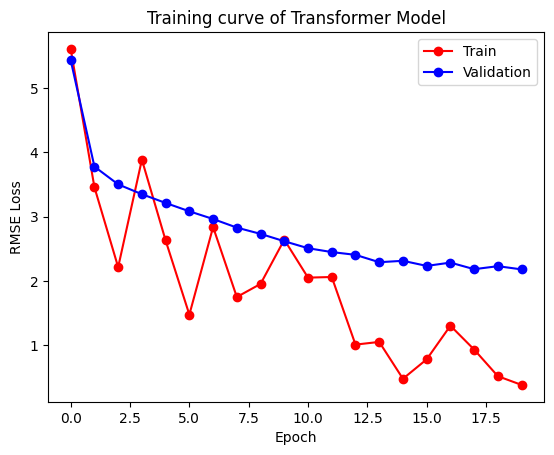

In [35]:
plt.plot(range(num_epochs), train_losses, "ro-", label="Train")
plt.plot(range(num_epochs), val_losses, "bo-", label = "Validation")
plt.title("Training curve of Transformer Model")
plt.xlabel("Epoch")
plt.ylabel("RMSE Loss")
plt.legend()

Root-Mean Squared Error (rmse) on Test Set: 2.18


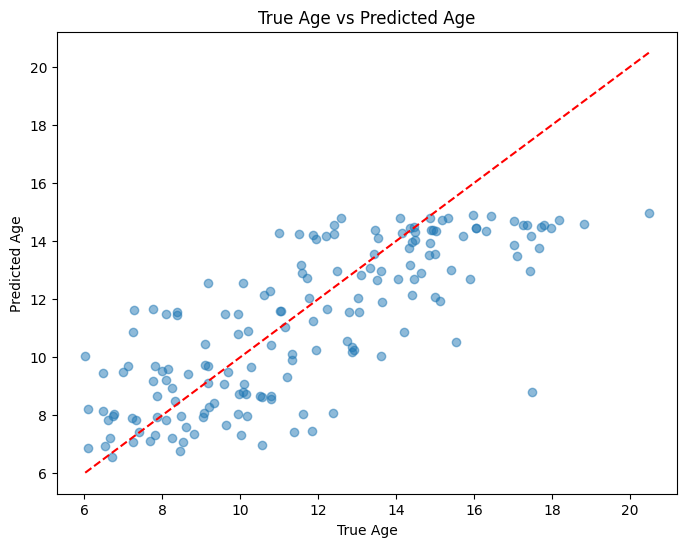

In [36]:
model.eval()

# Disable gradient calculation and make predictions
with torch.no_grad():
    test_predictions = model(X_test_tensor)  # Predict on the test set
    test_predictions = test_predictions.squeeze().numpy()  # Convert to NumPy array

# Evaluate predictions
rmse = mean_squared_error(y_test, test_predictions, squared = False)
print(f"Root-Mean Squared Error (rmse) on Test Set: {rmse:.2f}")

# Visualize predictions vs true values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, test_predictions, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--")  # Diagonal line
plt.xlabel("True Age")
plt.ylabel("Predicted Age")
plt.title("True Age vs Predicted Age")
plt.show()

## Finetune Transformer Models across All Parameter Sets

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Args:
            patience (int): How many epochs to wait after last time validation loss improved.
            min_delta (float): Minimum change in validation loss to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


def train_and_evaluate(params, X_train, y_train, X_val, y_val):

    # Unpack hyperparameters
    input_dim = 19921
    hidden_dim = params["hidden_dim"]
    num_heads = params["num_heads"]
    num_layers = params["num_layers"]
    ff_dim = params["ff_dim"]
    learning_rate = params["learning_rate"]
    batch_size = params["batch_size"]
    dropout_rate = params["dropout_rate"]

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

    # Create DataLoader for training and validation
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model, loss, and optimizer
    model = TransformerAgePredictor(input_dim, hidden_dim, num_heads, num_layers, ff_dim, dropout_rate)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    early_stopping = EarlyStopping(patience=5, min_delta=0.01)
    val_losses = []
    # Training loop
    num_epochs = 100
    for epoch in tqdm(range(num_epochs)):
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            loss.backward()
            optimizer.step()
        
        epoch_val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                loss = criterion(outputs.squeeze(), batch_y)
                epoch_val_loss += loss.item()
        val_losses.append(epoch_val_loss / len(val_loader))
        early_stopping(val_losses[-1])
        if early_stopping.early_stop:
            print("Early stopping triggered!")
            break

    # Evaluation on validation set
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_predictions = val_predictions.squeeze().numpy()
        # rmse = mean_absolute_error(y_val_tensor.numpy(), val_predictions)
        rmse = mean_squared_error(y_val_tensor.numpy(), val_predictions, squared=False)

    return model, rmse

param_distributions = {
    "hidden_dim": [128, 256, 512],
    "num_heads": [4, 8, 16],
    "num_layers": [2, 4, 6],
    "ff_dim": [256, 512, 1024],
    "learning_rate": [1e-4, 5e-4, 1e-3],
    "batch_size": [16, 32, 64],
    "dropout_rate": [0., 0.01, 0.1, 0.2],
}

results = []
for i, values in enumerate(product(*param_distributions.values())):
    if i == 10: #example run, this condition can be removed for extensive run.
        break
    params = dict(zip(param_distributions.keys(), values))
    _, rmse = train_and_evaluate(params, X_train_scaled, y_train, X_test_scaled, y_test)
    results.append({"params": params, "rmse": rmse})

# Find the best hyperparameters
best_result = min(results, key=lambda x: x["rmse"])
print("Best Hyperparameters:", best_result["params"])
print("Best rmse:", best_result["rmse"])

{'hidden_dim': 128, 'num_heads': 4, 'num_layers': 2, 'ff_dim': 256, 'learning_rate': 0.0001, 'batch_size': 16, 'dropout_rate': 0.0}


 39%|███▉      | 39/100 [01:07<01:46,  1.74s/it]


Early stopping triggered!
{'hidden_dim': 128, 'num_heads': 4, 'num_layers': 2, 'ff_dim': 256, 'learning_rate': 0.0001, 'batch_size': 16, 'dropout_rate': 0.01}


 25%|██▌       | 25/100 [00:44<02:14,  1.79s/it]


Early stopping triggered!
{'hidden_dim': 128, 'num_heads': 4, 'num_layers': 2, 'ff_dim': 256, 'learning_rate': 0.0001, 'batch_size': 16, 'dropout_rate': 0.1}


 18%|█▊        | 18/100 [00:32<02:27,  1.80s/it]


Early stopping triggered!
{'hidden_dim': 128, 'num_heads': 4, 'num_layers': 2, 'ff_dim': 256, 'learning_rate': 0.0001, 'batch_size': 16, 'dropout_rate': 0.2}


 14%|█▍        | 14/100 [00:25<02:37,  1.83s/it]


Early stopping triggered!
{'hidden_dim': 128, 'num_heads': 4, 'num_layers': 2, 'ff_dim': 256, 'learning_rate': 0.0001, 'batch_size': 32, 'dropout_rate': 0.0}


 61%|██████    | 61/100 [00:59<00:38,  1.03it/s]


Early stopping triggered!
{'hidden_dim': 128, 'num_heads': 4, 'num_layers': 2, 'ff_dim': 256, 'learning_rate': 0.0001, 'batch_size': 32, 'dropout_rate': 0.01}


 40%|████      | 40/100 [00:39<00:59,  1.01it/s]


Early stopping triggered!
{'hidden_dim': 128, 'num_heads': 4, 'num_layers': 2, 'ff_dim': 256, 'learning_rate': 0.0001, 'batch_size': 32, 'dropout_rate': 0.1}


 17%|█▋        | 17/100 [00:17<01:25,  1.03s/it]


Early stopping triggered!
{'hidden_dim': 128, 'num_heads': 4, 'num_layers': 2, 'ff_dim': 256, 'learning_rate': 0.0001, 'batch_size': 32, 'dropout_rate': 0.2}


 17%|█▋        | 17/100 [00:17<01:25,  1.03s/it]


Early stopping triggered!
{'hidden_dim': 128, 'num_heads': 4, 'num_layers': 2, 'ff_dim': 256, 'learning_rate': 0.0001, 'batch_size': 64, 'dropout_rate': 0.0}


 83%|████████▎ | 83/100 [00:51<00:10,  1.61it/s]


Early stopping triggered!
{'hidden_dim': 128, 'num_heads': 4, 'num_layers': 2, 'ff_dim': 256, 'learning_rate': 0.0001, 'batch_size': 64, 'dropout_rate': 0.01}


 40%|████      | 40/100 [00:25<00:38,  1.58it/s]

Early stopping triggered!
Best Hyperparameters: {'hidden_dim': 128, 'num_heads': 4, 'num_layers': 2, 'ff_dim': 256, 'learning_rate': 0.0001, 'batch_size': 16, 'dropout_rate': 0.0}
Best rmse: 2.2559717


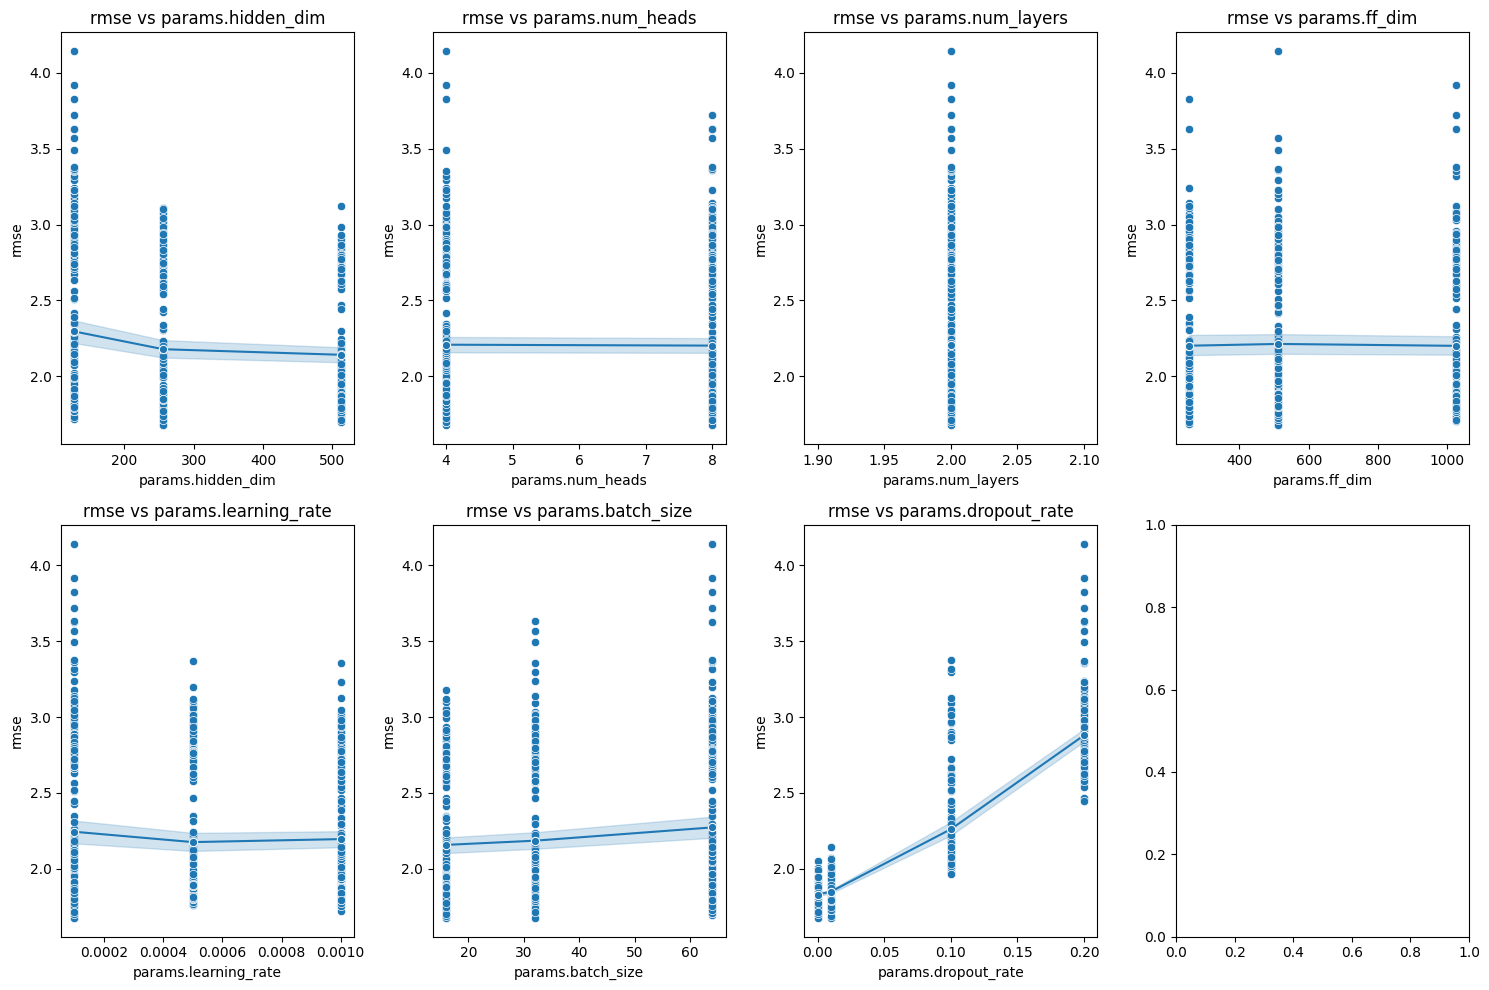

In [ ]:
transformer_results = pd.read_csv("./transformer_results.csv")

fig, axes = plt.subplots(2, 4, figsize=(15, 10))
axes = axes.flatten()

# Plot rmse against each parameter
for i, param in enumerate(transformer_results.columns[1:]):  # Exclude 'rmse'
    sns.scatterplot(x=transformer_results[param], y=transformer_results["rmse"], ax=axes[i])
    sns.lineplot(x=transformer_results[param], y=transformer_results["rmse"], ax=axes[i], marker='o')
    axes[i].set_title(f"rmse vs {param}")
    axes[i].set_xlabel(param)
    axes[i].set_ylabel("rmse")

plt.tight_layout()
plt.show()


### Final retrain with the best model


In [144]:
best_transformer_result = transformer_results[transformer_results.rmse == transformer_results.rmse.min()]
train_rmse = np.min(best_transformer_result.rmse)
best_transformer_result


,rmse,params.hidden_dim,params.num_heads,params.num_layers,params.ff_dim,params.learning_rate,params.batch_size,params.dropout_rate
364,1.675514,256,8,2,512,0.0001,32,0.0


In [ ]:
best_params = {
    "hidden_dim": best_transformer_result["params.hidden_dim"].to_numpy()[0],
    "num_heads": best_transformer_result["params.num_heads"].to_numpy()[0],
    "num_layers": best_transformer_result["params.num_layers"].to_numpy()[0],
    "ff_dim": best_transformer_result["params.ff_dim"].to_numpy()[0],
    "learning_rate": best_transformer_result["params.learning_rate"].to_numpy()[0],
    "batch_size": int(best_transformer_result["params.batch_size"].to_numpy()[0]),
    "dropout_rate": best_transformer_result["params.dropout_rate"].to_numpy()[0],
}

best_model, rmse = train_and_evaluate(best_params, X_train_scaled, y_train, X_test_scaled, y_test)

  0%|          | 0/100 [00:00<?, ?it/s]

 30%|███       | 30/100 [00:49<01:55,  1.65s/it]

Early stopping triggered!


Run prediction

Root-Mean Squared Error (rmse) on Test Set: 2.21


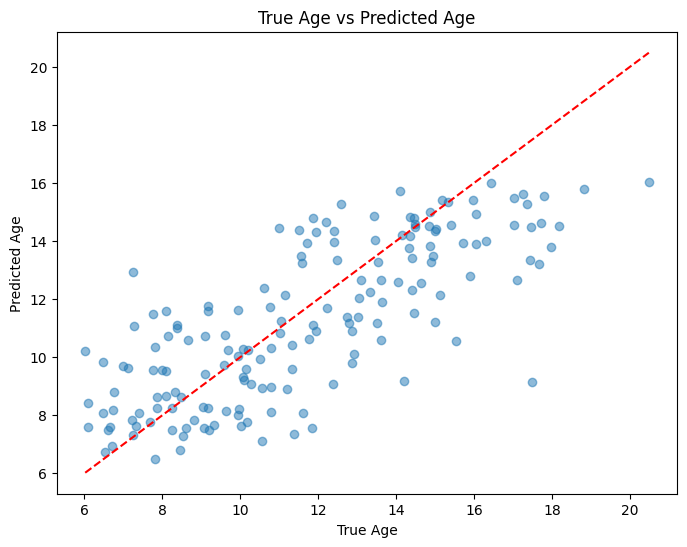

In [128]:
model.eval()

# Disable gradient calculation and make predictions
with torch.no_grad():
    test_predictions = best_model(X_test_tensor)  # Predict on the test set
    test_predictions = test_predictions.squeeze().numpy()  # Convert to NumPy array

# Evaluate predictions
test_rmse = mean_squared_error(y_test, test_predictions, squared = False)
print(f"Root-Mean Squared Error (rmse) on Test Set: {test_rmse:.2f}")

# Visualize predictions vs true values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, test_predictions, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--")  # Diagonal line
plt.xlabel("True Age")
plt.ylabel("Predicted Age")
plt.title("True Age vs Predicted Age")
plt.show()


Performance Breakdown by Gender:

Male (Sample Size: 103)
MSE: 4.822
MAE: 1.789
R²: 0.573

Female (Sample Size: 63)
MSE: 4.960
MAE: 1.695
R²: 0.535

Performance Breakdown by Age Category:

Age Category 10-15 (Sample Size: 79)
MSE: 3.842
MAE: 1.595
R²: -0.583

Age Category <10 (Sample Size: 59)
MSE: 3.756
MAE: 1.545
R²: -2.099

Age Category 16-18 (Sample Size: 25)
MSE: 9.664
MAE: 2.508
R²: -9.671

Age Category 18+ (Sample Size: 3)
MSE: 14.165
MAE: 3.719
R²: -14.041


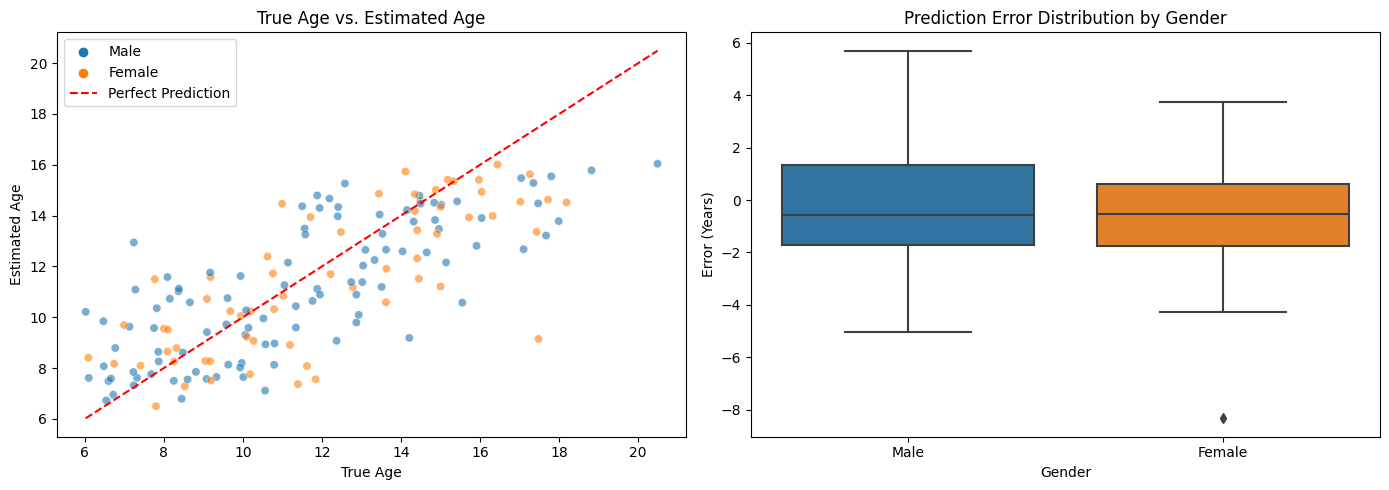

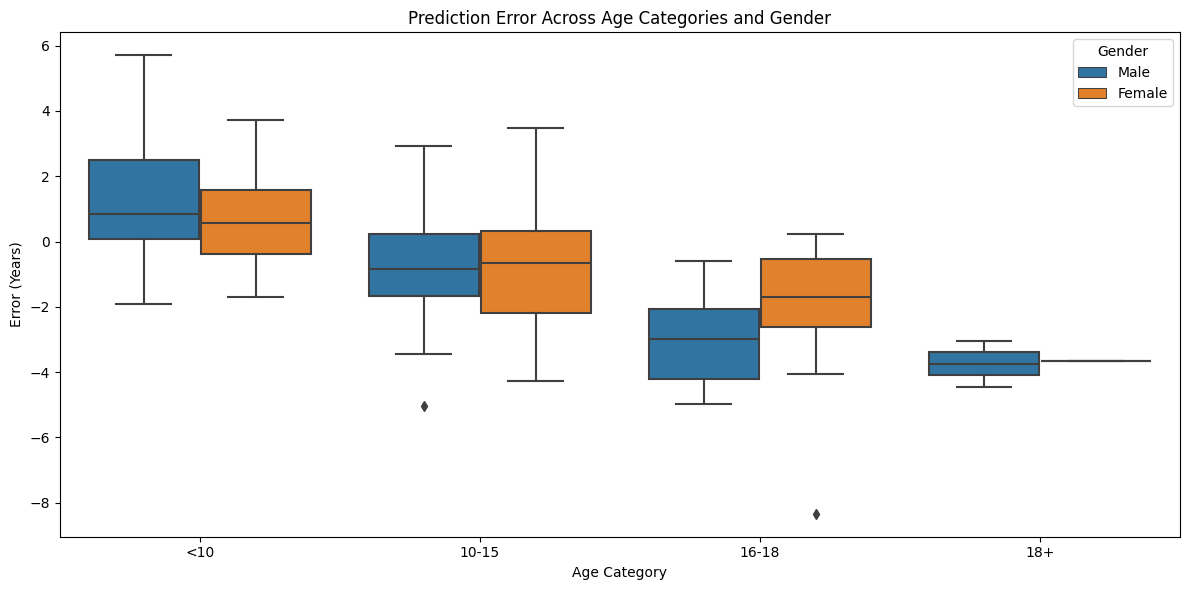

In [129]:
evaluation_df = pd.DataFrame({
    'True_Age': y_test,
    'Estimated_Age': test_predictions,
    'Gender': X_test['sex_Male'].replace({True: 'Male', False: 'Female'})
})

# Categorize ages into predefined groups
age_intervals = [0, 10, 15, 18, np.max(y_test)+1.]
age_categories = ['<10', '10-15', '16-18', '18+']
evaluation_df['Age_Category'] = pd.cut(evaluation_df['True_Age'], bins=age_intervals, labels=age_categories)

# Performance breakdown by gender
print("\nPerformance Breakdown by Gender:")
for gender in evaluation_df['Gender'].unique():
    subset = evaluation_df[evaluation_df['Gender'] == gender]
    print(f"\n{gender} (Sample Size: {len(subset)})")
    print(f"MSE: {mean_squared_error(subset['True_Age'], subset['Estimated_Age']):.3f}")
    print(f"MAE: {mean_absolute_error(subset['True_Age'], subset['Estimated_Age']):.3f}")
    print(f"R²: {r2_score(subset['True_Age'], subset['Estimated_Age']):.3f}")

# Performance breakdown by age category
print("\nPerformance Breakdown by Age Category:")
for category in evaluation_df['Age_Category'].unique():
    subset = evaluation_df[evaluation_df['Age_Category'] == category]
    print(f"\nAge Category {category} (Sample Size: {len(subset)})")
    print(f"MSE: {mean_squared_error(subset['True_Age'], subset['Estimated_Age']):.3f}")
    print(f"MAE: {mean_absolute_error(subset['True_Age'], subset['Estimated_Age']):.3f}")
    print(f"R²: {r2_score(subset['True_Age'], subset['Estimated_Age']):.3f}")

# Visualization
plt.figure(figsize=(14, 5))

# Scatter plot: Actual vs Predicted Age
plt.subplot(1, 2, 1)
sns.scatterplot(data=evaluation_df, x='True_Age', y='Estimated_Age', hue='Gender', alpha=0.6)
plt.plot([evaluation_df['True_Age'].min(), evaluation_df['True_Age'].max()], 
         [evaluation_df['True_Age'].min(), evaluation_df['True_Age'].max()], 
         linestyle='dashed', color='red', label='Perfect Prediction')
plt.title('True Age vs. Estimated Age')
plt.xlabel('True Age')
plt.ylabel('Estimated Age')
plt.legend()

# Box plot: Prediction Errors by Gender
plt.subplot(1, 2, 2)
evaluation_df['Error'] = evaluation_df['Estimated_Age'] - evaluation_df['True_Age']
sns.boxplot(data=evaluation_df, x='Gender', y='Error')
plt.title('Prediction Error Distribution by Gender')
plt.ylabel('Error (Years)')

plt.tight_layout()
plt.show()

# Box plot: Prediction Errors by Age Category and Gender
plt.figure(figsize=(12, 6))
sns.boxplot(data=evaluation_df, x='Age_Category', y='Error', hue='Gender')
plt.title('Prediction Error Across Age Categories and Gender')
plt.ylabel('Error (Years)')
plt.xlabel('Age Category')

plt.tight_layout()
plt.show()

## Training with PCA

Now we tune the number of PCA to acchieve the best model.

In [130]:
from sklearn.decomposition import PCA
PCA_COMPONENTS = np.linspace(1,min(X_train.shape), 20, dtype = int)


In [131]:
best_params = {
    "hidden_dim": 128,
    "num_heads": 4,
    "num_layers": 2,
    "ff_dim": 256,
    "learning_rate": 5e-4,
    "batch_size": 64,
    "dropout_rate": 0.,
}

val_mean_losses = []
for pca_comps in PCA_COMPONENTS:
    pca = PCA(n_components=pca_comps).fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)

    X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

    # Hyperparameters
    input_dim = pca_comps #number of pca
    hidden_dim = best_params["hidden_dim"]
    num_heads = best_params["num_heads"]
    num_layers = best_params["num_layers"]
    ff_dim = best_params["ff_dim"]
    batch_size = best_params["batch_size"]
    learning_rate = best_params["learning_rate"]
    num_epochs = 20

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model, loss, and optimizer
    model_pca = TransformerAgePredictor(input_dim, hidden_dim, num_heads, num_layers, ff_dim, dropout_rate=0.)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model_pca.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []
    # Training loop
    for epoch in range(num_epochs):
        model_pca.train()
        for batch_features, batch_ages in train_loader:
            optimizer.zero_grad()
            outputs = model_pca(batch_features)
            loss = criterion(outputs.squeeze(), batch_ages)
            loss.backward()
            optimizer.step()

        train_losses.append(loss.detach().numpy()**(1/2))
        model_pca.eval()
        with torch.no_grad():
            val_predictions = model_pca(X_test_tensor)
            val_predictions = val_predictions.squeeze().numpy()
            # rmse = mean_absolute_error(y_val_tensor.numpy(), val_predictions)
            rmse = mean_squared_error(y_test_tensor.numpy(), val_predictions, squared=False)

        val_losses.append(rmse)
        

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item()}")

    val_mean_losses.append(np.mean(val_losses))

Epoch 20/20, Train Loss: 7.114846229553223
Epoch 20/20, Train Loss: 4.1798295974731445
Epoch 20/20, Train Loss: 2.854933977127075
Epoch 20/20, Train Loss: 1.8437548875808716
Epoch 20/20, Train Loss: 4.554625034332275
Epoch 20/20, Train Loss: 3.1777849197387695
Epoch 20/20, Train Loss: 1.9431021213531494
Epoch 20/20, Train Loss: 2.6677792072296143
Epoch 20/20, Train Loss: 2.9566166400909424
Epoch 20/20, Train Loss: 3.0857646465301514
Epoch 20/20, Train Loss: 1.4718066453933716
Epoch 20/20, Train Loss: 2.1234517097473145
Epoch 20/20, Train Loss: 2.912903308868408
Epoch 20/20, Train Loss: 1.0900334119796753
Epoch 20/20, Train Loss: 1.2082046270370483
Epoch 20/20, Train Loss: 1.9086016416549683
Epoch 20/20, Train Loss: 3.22931170463562
Epoch 20/20, Train Loss: 1.2941625118255615
Epoch 20/20, Train Loss: 1.8684179782867432
Epoch 20/20, Train Loss: 1.0760236978530884


In [132]:
print("PCA components that have lowest RMSE: ", PCA_COMPONENTS[np.argmin(val_mean_losses)])

PCA components that have lowest RMSE:  247


Run PCA with optimized components

In [133]:
pca = PCA(n_components=PCA_COMPONENTS[np.argmin(val_mean_losses)]).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Hyperparameters
input_dim = PCA_COMPONENTS[np.argmin(val_mean_losses)] #number of pca
hidden_dim = best_params["hidden_dim"]
num_heads = best_params["num_heads"]
num_layers = best_params["num_layers"]
ff_dim = best_params["ff_dim"]
batch_size = best_params["batch_size"]
learning_rate = best_params["learning_rate"]
num_epochs = 100

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss, and optimizer
model_pca = TransformerAgePredictor(input_dim, hidden_dim, num_heads, num_layers, ff_dim, dropout_rate=0.)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_pca.parameters(), lr=learning_rate)

train_losses = []
val_losses = []
# Training loop
for epoch in range(num_epochs):
    model_pca.train()
    for batch_features, batch_ages in train_loader:
        optimizer.zero_grad()
        outputs = model_pca(batch_features)
        loss = criterion(outputs.squeeze(), batch_ages)
        loss.backward()
        optimizer.step()

    train_losses.append(loss.detach().numpy()**(1/2))
    model_pca.eval()
    with torch.no_grad():
        val_predictions = model_pca(X_test_tensor)
        val_predictions = val_predictions.squeeze().numpy()
        # rmse = mean_absolute_error(y_val_tensor.numpy(), val_predictions)
        rmse = mean_squared_error(y_test_tensor.numpy(), val_predictions, squared=False)

    val_losses.append(rmse)
    

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item()}")

Epoch 1/100, Train Loss: 57.64875030517578
Epoch 2/100, Train Loss: 19.557729721069336
Epoch 3/100, Train Loss: 12.391457557678223
Epoch 4/100, Train Loss: 11.154653549194336
Epoch 5/100, Train Loss: 11.223958015441895
Epoch 6/100, Train Loss: 10.750863075256348
Epoch 7/100, Train Loss: 9.797492027282715
Epoch 8/100, Train Loss: 8.310270309448242
Epoch 9/100, Train Loss: 9.155011177062988
Epoch 10/100, Train Loss: 6.144242286682129
Epoch 11/100, Train Loss: 4.096646785736084
Epoch 12/100, Train Loss: 6.724491119384766
Epoch 13/100, Train Loss: 5.72725772857666
Epoch 14/100, Train Loss: 6.966889381408691
Epoch 15/100, Train Loss: 5.251570701599121
Epoch 16/100, Train Loss: 8.155444145202637
Epoch 17/100, Train Loss: 2.8810641765594482
Epoch 18/100, Train Loss: 3.581808567047119
Epoch 19/100, Train Loss: 2.405799388885498
Epoch 20/100, Train Loss: 2.49005126953125
Epoch 21/100, Train Loss: 1.6689245700836182
Epoch 22/100, Train Loss: 4.098413944244385
Epoch 23/100, Train Loss: 1.02685725

In [134]:
train_rmse_pca = np.min(train_losses)
train_rmse_pca

0.11884612

Root-Mean Squared Error (rmse) on Test Set: 2.39


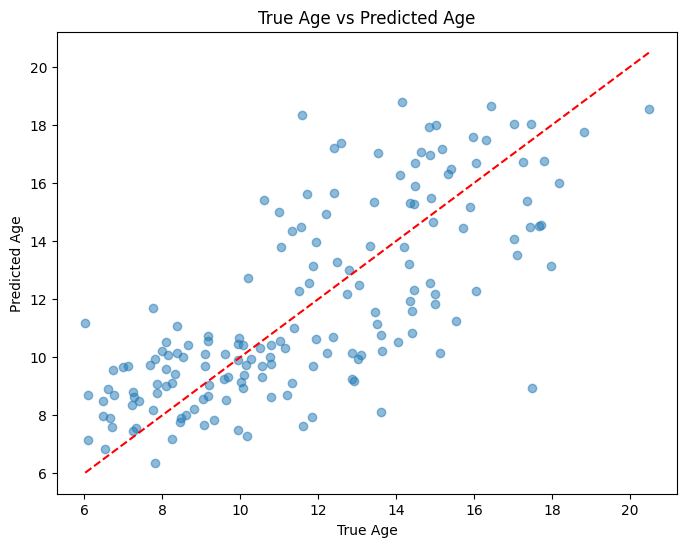

In [135]:
model_pca.eval()

# Disable gradient calculation and make predictions
with torch.no_grad():
    test_predictions = model_pca(X_test_tensor)  # Predict on the test set
    test_predictions = test_predictions.squeeze().numpy()  # Convert to NumPy array

# Evaluate predictions
test_rmse_pca = mean_squared_error(y_test, test_predictions, squared = False)
print(f"Root-Mean Squared Error (rmse) on Test Set: {test_rmse_pca:.2f}")

# Visualize predictions vs true values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, test_predictions, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--")  # Diagonal line
plt.xlabel("True Age")
plt.ylabel("Predicted Age")
plt.title("True Age vs Predicted Age")
plt.show()

In [137]:
evaluation_df = pd.DataFrame({
    'True_Age': y_test,
    'Estimated_Age': test_predictions,
    'Gender': X_test['sex_Male'].replace({True: 'Male', False: 'Female'})
})


Performance Breakdown by Gender:

Male (Sample Size: 103)
MSE: 5.203
MAE: 1.847
R²: 0.540

Female (Sample Size: 63)
MSE: 6.506
MAE: 2.055
R²: 0.390

Performance Breakdown by Age Category:

Age Category 10-15 (Sample Size: 79)
MSE: 6.746
MAE: 2.167
R²: -1.780

Age Category <10 (Sample Size: 59)
MSE: 2.819
MAE: 1.381
R²: -1.326

Age Category 16-18 (Sample Size: 25)
MSE: 9.479
MAE: 2.478
R²: -9.467

Age Category 18+ (Sample Size: 3)
MSE: 3.189
MAE: 1.719
R²: -2.387


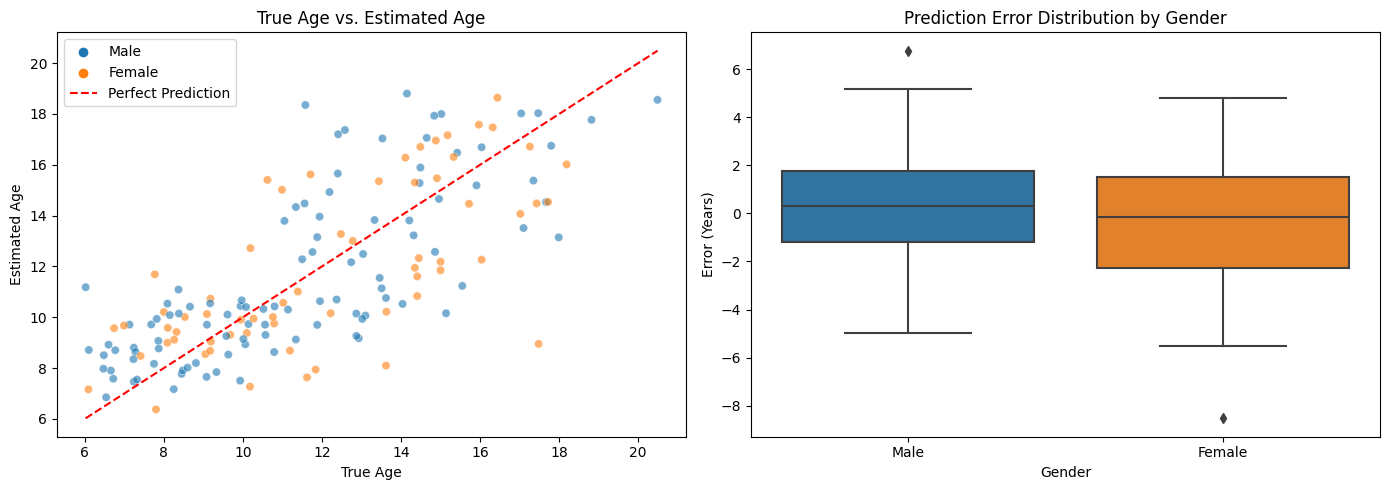

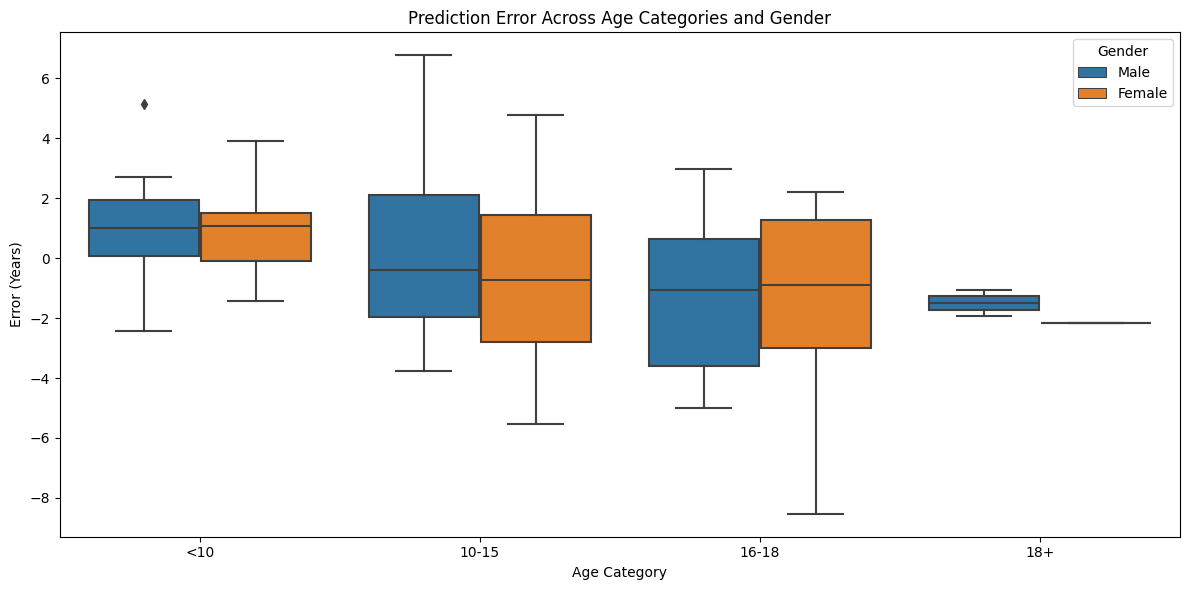

In [138]:
# Categorize ages into predefined groups
age_intervals = [0, 10, 15, 18, np.max(y_test)+1.]
age_categories = ['<10', '10-15', '16-18', '18+']
evaluation_df['Age_Category'] = pd.cut(evaluation_df['True_Age'], bins=age_intervals, labels=age_categories)

# Performance breakdown by gender
print("\nPerformance Breakdown by Gender:")
for gender in evaluation_df['Gender'].unique():
    subset = evaluation_df[evaluation_df['Gender'] == gender]
    print(f"\n{gender} (Sample Size: {len(subset)})")
    print(f"MSE: {mean_squared_error(subset['True_Age'], subset['Estimated_Age']):.3f}")
    print(f"MAE: {mean_absolute_error(subset['True_Age'], subset['Estimated_Age']):.3f}")
    print(f"R²: {r2_score(subset['True_Age'], subset['Estimated_Age']):.3f}")

# Performance breakdown by age category
print("\nPerformance Breakdown by Age Category:")
for category in evaluation_df['Age_Category'].unique():
    subset = evaluation_df[evaluation_df['Age_Category'] == category]
    print(f"\nAge Category {category} (Sample Size: {len(subset)})")
    print(f"MSE: {mean_squared_error(subset['True_Age'], subset['Estimated_Age']):.3f}")
    print(f"MAE: {mean_absolute_error(subset['True_Age'], subset['Estimated_Age']):.3f}")
    print(f"R²: {r2_score(subset['True_Age'], subset['Estimated_Age']):.3f}")

# Visualization
plt.figure(figsize=(14, 5))

# Scatter plot: Actual vs Predicted Age
plt.subplot(1, 2, 1)
sns.scatterplot(data=evaluation_df, x='True_Age', y='Estimated_Age', hue='Gender', alpha=0.6)
plt.plot([evaluation_df['True_Age'].min(), evaluation_df['True_Age'].max()], 
         [evaluation_df['True_Age'].min(), evaluation_df['True_Age'].max()], 
         linestyle='dashed', color='red', label='Perfect Prediction')
plt.title('True Age vs. Estimated Age')
plt.xlabel('True Age')
plt.ylabel('Estimated Age')
plt.legend()

# Box plot: Prediction Errors by Gender
plt.subplot(1, 2, 2)
evaluation_df['Error'] = evaluation_df['Estimated_Age'] - evaluation_df['True_Age']
sns.boxplot(data=evaluation_df, x='Gender', y='Error')
plt.title('Prediction Error Distribution by Gender')
plt.ylabel('Error (Years)')

plt.tight_layout()
plt.show()

# Box plot: Prediction Errors by Age Category and Gender
plt.figure(figsize=(12, 6))
sns.boxplot(data=evaluation_df, x='Age_Category', y='Error', hue='Gender')
plt.title('Prediction Error Across Age Categories and Gender')
plt.ylabel('Error (Years)')
plt.xlabel('Age Category')

plt.tight_layout()
plt.show()

### Final Report of RMSEs

In [145]:
pd.DataFrame({"Model":["Transformer","Transformer with PCA"],"Train RMSE":[train_rmse, train_rmse_pca], "Test RMSE":[test_rmse, test_rmse_pca]})

,Model,Train RMSE,Test RMSE
0,Transformer,1.675514,2.207814
1,Transformer with PCA,0.118846,2.386956
